🏦 Banking Customer Churn - Machine Learning Prediction
📊 Loaded 10000 customers for modeling
🔧 Preprocessing data...
Features: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'txn_count', 'days_since_last_txn', 'country_encoded', 'gender_encoded']
Target variable: churn
Feature matrix shape: (10000, 12)
Target distribution:
churn
0    7327
1    2673
Name: count, dtype: int64
Churn rate: 26.73%

⚖️ Handling class imbalance...
Class 0 (Retained): 7327
Class 1 (Churned): 2673
After balancing:
Class 0: 7327
Class 1: 7327

📊 Splitting data into train/test sets...
Training set: (11723, 12)
Test set: (2931, 12)
✅ Features scaled using StandardScaler

🤖 Training models...
Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.6455, AUC: 0.6999
Training Random Forest...
✅ Random Forest - Accuracy: 0.8946, AUC: 0.9636
Training Gradient Boosting...
✅ Gradient Boosting - Accuracy: 0.7056, AUC: 0.7769
Training Support 

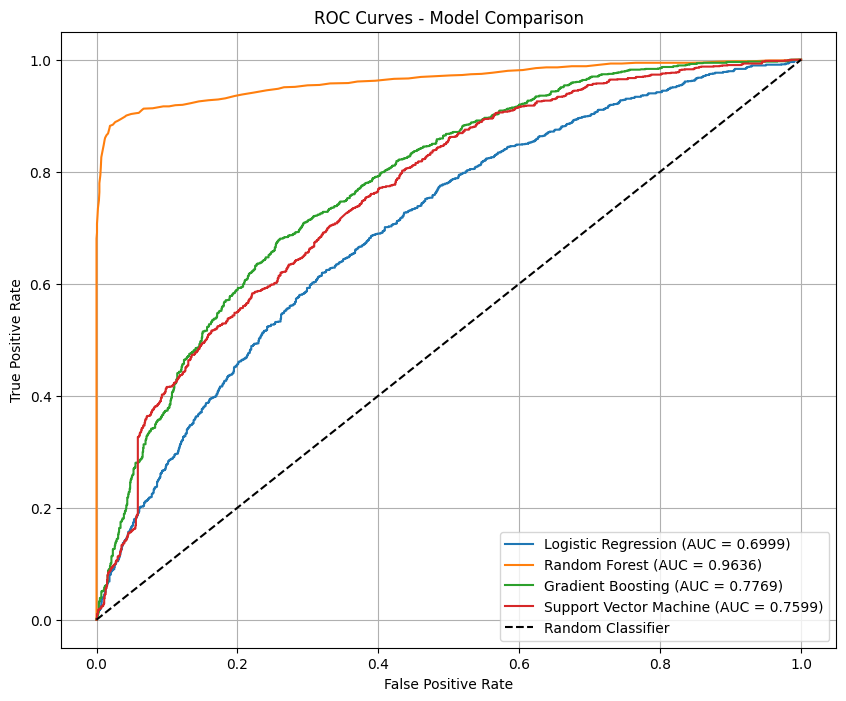


🎯 Best Model: Random Forest

📈 Best Model Performance:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1466
           1       0.87      0.92      0.90      1465

    accuracy                           0.89      2931
   macro avg       0.90      0.89      0.89      2931
weighted avg       0.90      0.89      0.89      2931



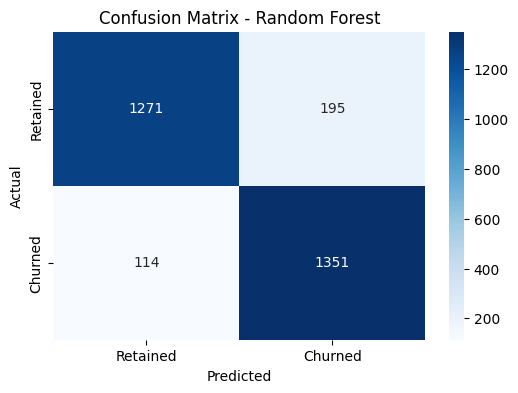

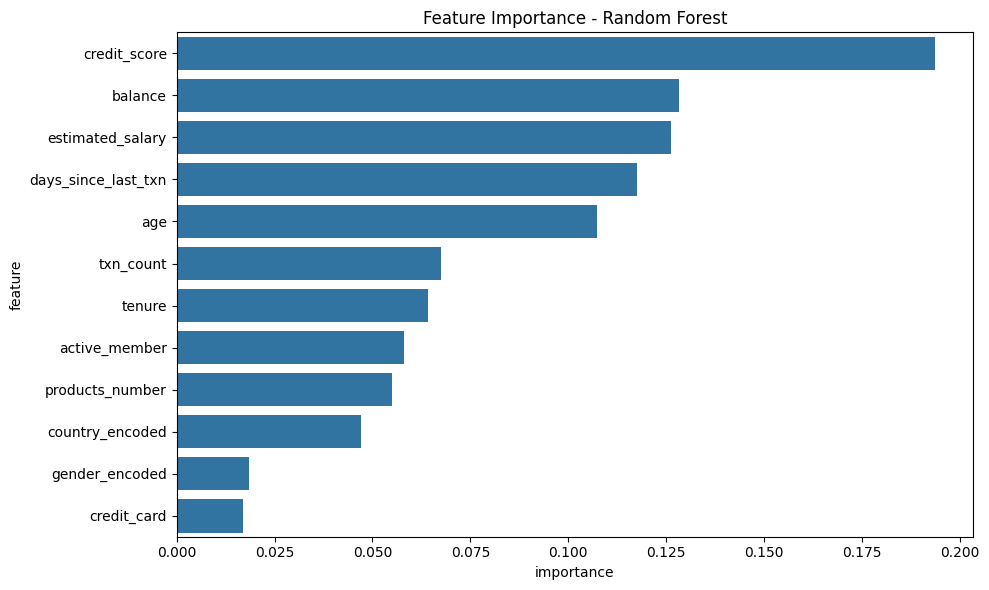


🔍 Top 10 Most Important Features:
                feature  importance
0          credit_score    0.193695
3               balance    0.128233
7      estimated_salary    0.126105
9   days_since_last_txn    0.117621
1                   age    0.107275
8             txn_count    0.067614
2                tenure    0.064062
6         active_member    0.057994
4       products_number    0.055017
10      country_encoded    0.046991

🎛️ Tuning hyperparameters for Random Forest...
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score: 0.9525
✅ Tuned Random Forest - Accuracy: 0.8942, AUC: 0.9644

💼 BUSINESS IMPACT ANALYSIS
💰 Business Impact at Different Thresholds:
   Threshold  Customers Targeted  Successful Retentions  Missed Churns  \
0        0.3                2129                   1422             43   
1        0.5                1569                   1356            109   
2        0.7                1296                   1272 

In [3]:
# Banking Project - Churn Prediction with Machine Learning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)
from sklearn.utils import resample
import warnings

warnings.filterwarnings("ignore")

# Setup
import sys
import os

# Add shared modules to path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from shared.utils.helpers import VisualizationHelper

VisualizationHelper.setup_plotting()

print("🏦 Banking Customer Churn - Machine Learning Prediction")
print("=" * 60)

# Load the enriched data
customers = pd.read_csv("../../data/processed/banking_customers_clean.csv")
print(f"📊 Loaded {len(customers)} customers for modeling")

# Select features for modeling
features = [
    "credit_score",
    "age",
    "tenure",
    "balance",
    "products_number",
    "credit_card",
    "active_member",
    "estimated_salary",
    "txn_count",
    "days_since_last_txn",
]

# Encode categorical variables
print("🔧 Preprocessing data...")
customers_ml = customers.copy()

# Encode country and gender
le_country = LabelEncoder()
le_gender = LabelEncoder()

customers_ml["country_encoded"] = le_country.fit_transform(customers_ml["country"])
customers_ml["gender_encoded"] = le_gender.fit_transform(customers_ml["gender"])

# Add encoded features to feature set
features_extended = features + ["country_encoded", "gender_encoded"]

X = customers_ml[features_extended]
y = customers_ml["churn"]

print(f"Features: {features_extended}")
print(f"Target variable: churn")
print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Churn rate: {y.mean():.2%}")

# Check class imbalance
print("\n⚖️ Handling class imbalance...")
churn_0 = customers_ml[customers_ml["churn"] == 0]
churn_1 = customers_ml[customers_ml["churn"] == 1]

print(f"Class 0 (Retained): {len(churn_0)}")
print(f"Class 1 (Churned): {len(churn_1)}")

# Upsample the minority class
churn_1_upsampled = resample(
    churn_1, replace=True, n_samples=len(churn_0), random_state=42
)

# Combine majority class with upsampled minority class
customers_balanced = pd.concat([churn_0, churn_1_upsampled])

print(f"After balancing:")
print(f"Class 0: {len(customers_balanced[customers_balanced['churn'] == 0])}")
print(f"Class 1: {len(customers_balanced[customers_balanced['churn'] == 1])}")

X_balanced = customers_balanced[features_extended]
y_balanced = customers_balanced["churn"]

# Split data into train and test sets
print("\n📊 Splitting data into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42, probability=True),
}

# Train and evaluate models
results = {}
feature_importances = {}

print("\n🤖 Training models...")
for name, model in models.items():
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = model.score(X_test_scaled, y_test)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        "model": model,
        "accuracy": accuracy,
        "auc": auc,
        "predictions": y_pred,
        "probabilities": y_pred_proba,
    }

    # Store feature importances for tree-based models
    if hasattr(model, "feature_importances_"):
        feature_importances[name] = model.feature_importances_

    print(f"✅ {name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

# Compare model performance
model_comparison = pd.DataFrame(
    {
        "Model": list(results.keys()),
        "Accuracy": [results[name]["accuracy"] for name in results.keys()],
        "AUC": [results[name]["auc"] for name in results.keys()],
    }
).sort_values("AUC", ascending=False)

print("\n📊 Model Performance Comparison:")
print(model_comparison)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result["probabilities"])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.4f})')

plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Model Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Select the best model based on AUC
best_model_name = model_comparison.iloc[0]["Model"]
best_model = results[best_model_name]["model"]
best_predictions = results[best_model_name]["predictions"]
best_probabilities = results[best_model_name]["probabilities"]

print(f"\n🎯 Best Model: {best_model_name}")

# Detailed evaluation of the best model
print("\n📈 Best Model Performance:")
print(classification_report(y_test, best_predictions))

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Retained", "Churned"],
    yticklabels=["Retained", "Churned"],
)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Feature importance for tree-based models
if best_model_name in ["Random Forest", "Gradient Boosting"]:
    feature_importance = pd.DataFrame(
        {"feature": features_extended, "importance": best_model.feature_importances_}
    ).sort_values("importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x="importance", y="feature")
    plt.title(f"Feature Importance - {best_model_name}")
    plt.tight_layout()
    plt.show()

    print("\n🔍 Top 10 Most Important Features:")
    print(feature_importance.head(10))

# For Logistic Regression, show coefficients
elif best_model_name == "Logistic Regression":
    coefficients = pd.DataFrame(
        {"feature": features_extended, "coefficient": best_model.coef_[0]}
    ).sort_values("coefficient", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=coefficients, x="coefficient", y="feature")
    plt.title("Feature Coefficients - Logistic Regression")
    plt.tight_layout()
    plt.show()

    print("\n🔍 Feature Coefficients:")
    print(coefficients)

# Hyperparameter tuning for the best model
print(f"\n🎛️ Tuning hyperparameters for {best_model_name}...")

if best_model_name == "Random Forest":
    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
    }

    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
    )

    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Update results with tuned model
y_pred_tuned = best_model.predict(X_test_scaled)
y_pred_proba_tuned = best_model.predict_proba(X_test_scaled)[:, 1]

accuracy_tuned = best_model.score(X_test_scaled, y_test)
auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(
    f"✅ Tuned {best_model_name} - Accuracy: {accuracy_tuned:.4f}, AUC: {auc_tuned:.4f}"
)

# Calculate potential business impact
print("\n💼 BUSINESS IMPACT ANALYSIS")
print("=" * 50)

# Business assumptions
avg_customer_value = 500  # Annual revenue per customer
retention_cost = 100  # Cost to retain an at-risk customer
acquisition_cost = 1000  # Cost to acquire a new customer

# Calculate at different probability thresholds
thresholds = [0.3, 0.5, 0.7]
business_impact = []

for threshold in thresholds:
    # Predict churn based on threshold
    y_pred_business = (best_probabilities >= threshold).astype(int)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_business).ravel()

    # Business calculations
    customers_targeted = tp + fp
    successful_retentions = tp
    missed_churns = fn

    retention_savings = successful_retentions * acquisition_cost
    retention_costs = customers_targeted * retention_cost
    missed_opportunity_cost = missed_churns * acquisition_cost

    net_benefit = retention_savings - retention_costs - missed_opportunity_cost

    business_impact.append(
        {
            "Threshold": threshold,
            "Customers Targeted": customers_targeted,
            "Successful Retentions": successful_retentions,
            "Missed Churns": missed_churns,
            "Net Benefit": net_benefit,
        }
    )

business_df = pd.DataFrame(business_impact)
print("💰 Business Impact at Different Thresholds:")
print(business_df)

# Find optimal threshold
optimal_threshold = business_df.loc[business_df["Net Benefit"].idxmax(), "Threshold"]
print(f"\n🎯 Optimal threshold for maximum net benefit: {optimal_threshold:.2f}")

# Prepare model for deployment
print("\n🚀 Preparing model for deployment...")

import joblib

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save the best model and preprocessing objects
model_artifacts = {
    "model": best_model,
    "scaler": scaler,
    "features": features_extended,
    "label_encoders": {"country": le_country, "gender": le_gender},
    "optimal_threshold": optimal_threshold,
}

joblib.dump(model_artifacts, "../models/churn_model.pkl")

print("✅ Model artifacts saved to '../models/churn_model.pkl'")


# Create a prediction function for future use
def predict_churn(customer_data, model_path="../models/churn_model.pkl"):
    """Predict churn probability for a new customer"""
    artifacts = joblib.load(model_path)

    # Preprocess input
    customer_df = pd.DataFrame([customer_data])

    # Encode categorical variables
    customer_df["country_encoded"] = artifacts["label_encoders"]["country"].transform(
        [customer_data.get("country", "Germany")]
    )[0]
    customer_df["gender_encoded"] = artifacts["label_encoders"]["gender"].transform(
        [customer_data.get("gender", "Male")]
    )[0]

    # Select features and scale
    X_new = customer_df[artifacts["features"]]
    X_new_scaled = artifacts["scaler"].transform(X_new)

    # Predict
    probability = artifacts["model"].predict_proba(X_new_scaled)[0, 1]
    prediction = probability >= artifacts["optimal_threshold"]

    return {
        "churn_probability": probability,
        "churn_prediction": bool(prediction),
        "risk_level": "High" if prediction else "Low",
    }


# Test the prediction function
sample_customer = {
    "credit_score": 650,
    "age": 45,
    "tenure": 3,
    "balance": 50000,
    "products_number": 2,
    "credit_card": 1,
    "active_member": 0,
    "estimated_salary": 75000,
    "txn_count": 15,
    "days_since_last_txn": 30,
    "country": "Germany",
    "gender": "Male",
}

prediction_result = predict_churn(sample_customer)
print(f"\n🧪 Sample Prediction Test:")
print(f"Customer data: {sample_customer}")
print(f"Prediction result: {prediction_result}")

print("\n🎯 MACHINE LEARNING PROJECT SUMMARY")
print("=" * 50)

print(f"✅ Best Model: {best_model_name}")
print(f"✅ Test Accuracy: {accuracy_tuned:.4f}")
print(f"✅ Test AUC: {auc_tuned:.4f}")
print(f"✅ Optimal Threshold: {optimal_threshold:.2f}")
print(f"✅ Features Used: {len(features_extended)}")
print(f"✅ Model Saved: ../models/churn_model.pkl")

print("\n📊 Key Business Insights:")
print(f"• Churn rate in dataset: {customers['churn'].mean():.2%}")
print(
    f"• Most important features: {feature_importance['feature'].head(3).tolist() if 'feature_importance' in locals() else 'N/A'}"
)
print(f"• Maximum net benefit at {optimal_threshold:.0%} probability threshold")

print("\n🚀 Next Steps:")
print("1. Use the saved model in the Streamlit dashboard")
print("2. Implement real-time predictions in production")
print("3. Set up monitoring for model performance")
print("4. Retrain model periodically with new data")